In [1]:
"""

https://www.codingfinance.com/post/2019-07-01-analyze-ff-factor-python/

"""

'\n\nhttps://www.codingfinance.com/post/2019-07-01-analyze-ff-factor-python/\n\n'

In [2]:
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
import cvxpy as cp
import sys
import warnings
import urllib.request
import zipfile
import seaborn as sns

from pypfopt.expected_returns import mean_historical_return, ema_historical_return
from pypfopt.risk_models import CovarianceShrinkage, risk_matrix
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import objective_functions
from pypfopt import plotting
from pypfopt import black_litterman, risk_models
from pypfopt.black_litterman import BlackLittermanModel

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_excel('test_3_AC.xlsx', skiprows=5, index_col=0,date_parser=True)
df_header = pd.read_excel('test_3_AC.xlsx', skiprows=2, index_col=0,date_parser=True)
df.columns = df_header.columns
df.dropna(inplace=True)
df=df.loc['2001-08-21':,:]
pd.to_datetime(df.index)
cov=df.cov()

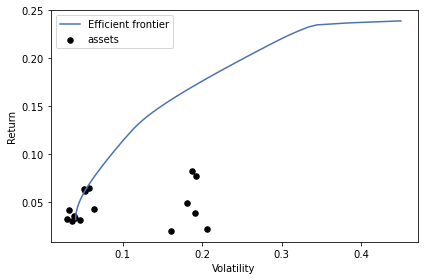

In [4]:
"""
Define expected return and risk models
"""

mu = mean_historical_return(df)
S = CovarianceShrinkage(df).ledoit_wolf()
risk_free_rate = 0.02
Tgt_Ret = 0.05
Tgt_Vol = 0.042
    
ef = EfficientFrontier(mu, S, weight_bounds=(None, None))
ef.add_constraint(lambda w: w[0] >= 0.2)
ef.add_constraint(lambda w: w[2] == 0.15)
ef.add_constraint(lambda w: w[3] + w[4] <= 0.10)

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)
plt.show()

<AxesSubplot:>

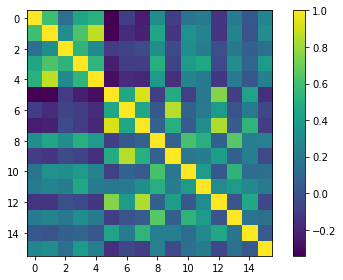

In [5]:
"""
Plotting Variance Covariance Matrix
"""
plotting.plot_covariance(S, plot_correlation=True, show_tickers=False)

Expected annual return: 5.1%
Annual volatility: 3.0%
Sharpe Ratio: 1.05


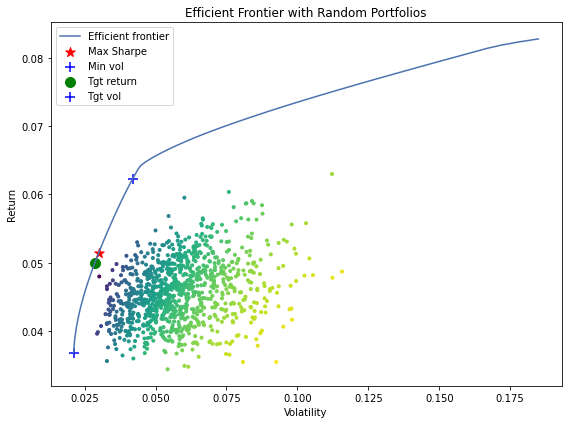

,S&P 500 Total Return,MSCI EUROPE NR,TOPIX INDEX (TOKYO),MSCI Daily TR Net Emergi,SMI GROSS TOTAL RETURN,U.S. Treasury,Treasury,U.S. Aggregate,U.S. Corporate High Yield,Pan-Euro Aggregate,Pan-European High Yield,EM Hard Currency Aggregate,LUMSTRUU Index,SPLSTAUSAll Loans,CMBS,BBG Commodity TR
Weights Sharpe,0.01582,0.0,0.0,0.0,0.00000,0.07925,0.08714,0.0,0.19660,0.00000,0.17860,0.16033,0.16162,0.12064,0.0,0.00000
Weights Min Vol,0.00462,0.0,0.0,0.0,0.01066,0.00000,0.09854,0.0,0.00000,0.10104,0.00000,0.00000,0.39285,0.38497,0.0,0.00733
Weights Tgt Ret,0.01560,0.0,0.0,0.0,0.00000,0.06907,0.09514,0.0,0.17484,0.00000,0.16435,0.14258,0.18825,0.15017,0.0,0.00000
Weights Tgt Vol,0.01115,0.0,0.0,0.0,0.00000,0.04917,0.00000,0.0,0.33003,0.00000,0.28196,0.32769,0.00000,0.00000,0.0,0.00000


In [6]:
def plot_efficient_frontier_and_portfolios(mu, S, risk_free_rate, Tgt_Ret, Tgt_Vol):  
    # Optimize portfolio for maximal Sharpe ratio 
    ef = EfficientFrontier(mu, S, weight_bounds=(0,1))
    fig, ax = plt.subplots(figsize=(8,6))
    ef_max_sharpe = copy.deepcopy(ef)
    plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)
    
    # Find the max sharpe portfolio
    ef_max_sharpe = EfficientFrontier(mu, S, weight_bounds=(0,1))
    ef_max_sharpe.max_sharpe(risk_free_rate)
    ret_tangent, std_tangent, _ =   ef_max_sharpe.portfolio_performance(risk_free_rate)
    ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r",     label="Max Sharpe")
    
    # Find the min vol portfolio
    ef_min_vol = EfficientFrontier(mu, S, weight_bounds=(0,1))
    ef_min_vol.min_volatility()
    ret_tangent, std_tangent, _ =   ef_min_vol.portfolio_performance()
    ax.scatter(std_tangent, ret_tangent, marker="+", s=100, c="b",     label="Min vol")
    
    # Find the target return portfolio
    ef_ret = EfficientFrontier(mu, S, weight_bounds=(0,1))
    ef_ret.efficient_return(Tgt_Ret)
    ret_tangent, std_tangent, _ =   ef_ret.portfolio_performance()
    ax.scatter(std_tangent, ret_tangent, marker="o", s=100, c="g",     label="Tgt return")
    
    # Find the tgt vol portfolio
    ef_tgt_vol = EfficientFrontier(mu, S, weight_bounds=(0,1))
    ef_tgt_vol.efficient_risk(Tgt_Vol)
    ret_tangent, std_tangent, _ =   ef_tgt_vol.portfolio_performance()
    ax.scatter(std_tangent, ret_tangent, marker="+", s=100, c="b",     label="Tgt vol")
    
    

# Generate random portfolios
    n_samples = 1000
    w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
    rets = w.dot(ef.expected_returns)
    stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
    sharpes = rets / stds
    ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")
# Output
    ax.set_title("Efficient Frontier with Random Portfolios")
    ax.legend()
    plt.tight_layout()
    plt.show()
        
plot_efficient_frontier_and_portfolios(mu, S, risk_free_rate, Tgt_Ret, Tgt_Vol)

ef_max_sharpe = EfficientFrontier(mu, S, weight_bounds=(0,1))
w_sharpe = ef_max_sharpe.max_sharpe()
cleaned_weights_sharpe = ef_max_sharpe.clean_weights()
df_w = pd.DataFrame(cleaned_weights_sharpe, columns=cleaned_weights_sharpe.keys(), index=['Weights Sharpe'])

ef_min_vol = EfficientFrontier(mu, S, weight_bounds=(0,1))
w_vol = ef_min_vol.min_volatility()
cleaned_weights_vol = ef_min_vol.clean_weights()
df_min_vol = pd.DataFrame(cleaned_weights_vol, columns=cleaned_weights_vol.keys(), index=['Weights Min Vol'])

ef_ret = EfficientFrontier(mu, S, weight_bounds=(0,1))
w_ret = ef_ret.efficient_return(Tgt_Ret)
cleaned_weights_ret = ef_ret.clean_weights()
df_ret = pd.DataFrame(cleaned_weights_ret, columns=cleaned_weights_ret.keys(), index=['Weights Tgt Ret'])

ef_tgt_vol = EfficientFrontier(mu, S, weight_bounds=(0,1))
w_vol = ef_tgt_vol.efficient_risk(Tgt_Vol)
cleaned_weights_vol = ef_tgt_vol.clean_weights()
df_tgt_vol = pd.DataFrame(cleaned_weights_vol, columns=cleaned_weights_vol.keys(), index=['Weights Tgt Vol'])


df_w = pd.concat([df_w,df_min_vol,df_ret,df_tgt_vol])
df_w

In [7]:
df_ret = df.pct_change().dropna()

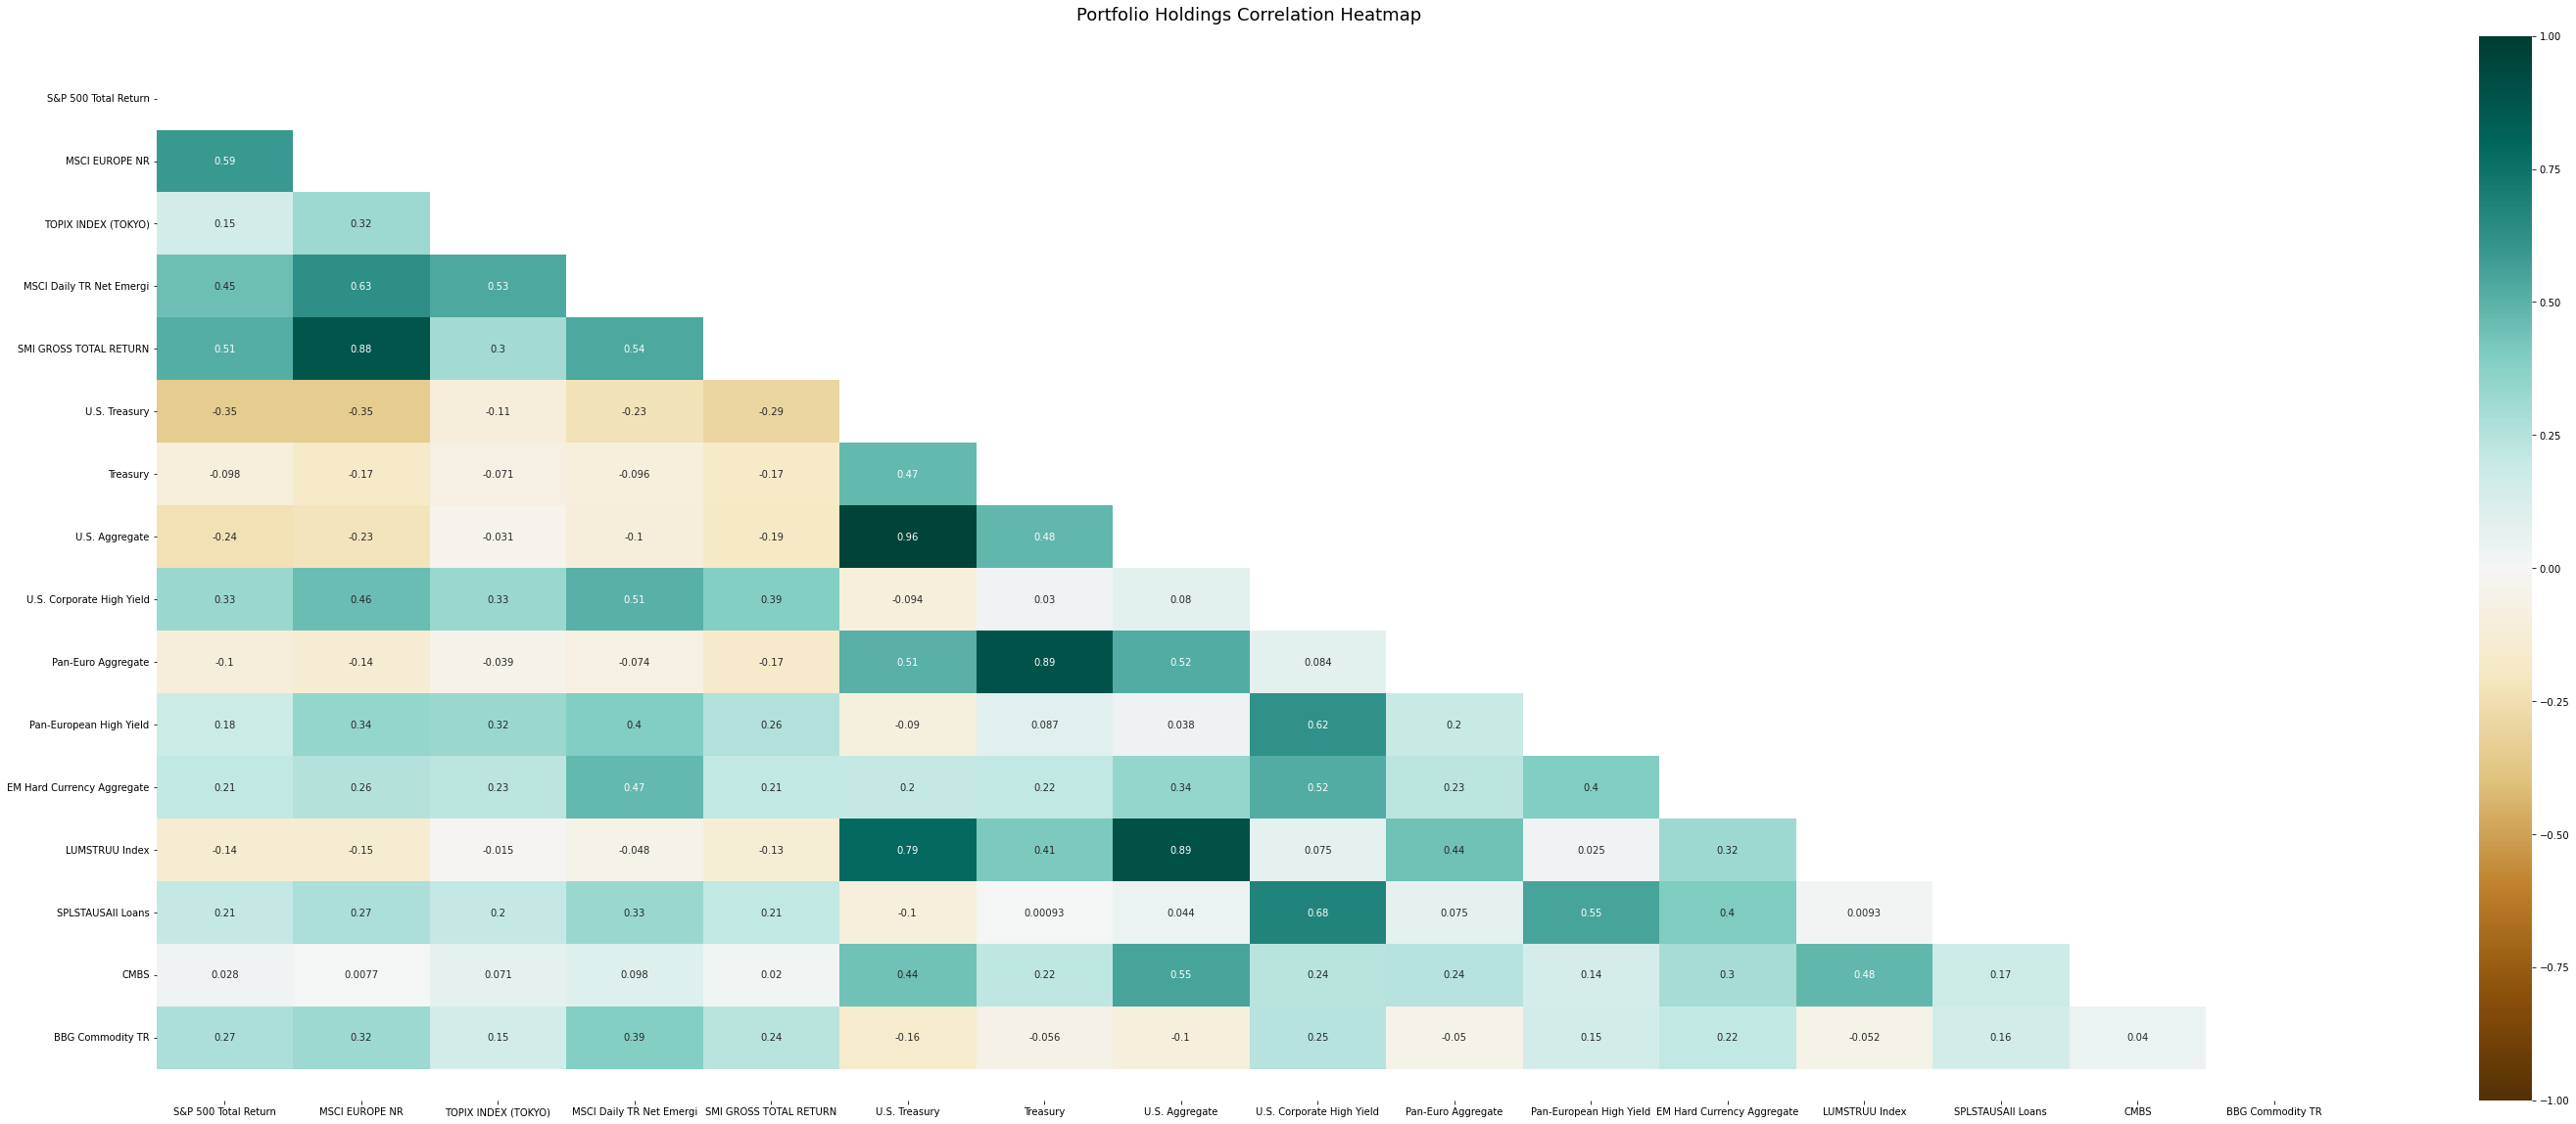

In [8]:
plt.figure(figsize=(50, 20))
mask = np.triu(np.ones_like(df_ret.corr(), dtype='bool'))
ax = sns.heatmap(df_ret.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
ax.set_title('Portfolio Holdings Correlation Heatmap', fontdict={'fontsize':18}, pad=16)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.savefig('.jpg', dpi=300, bbox_inches='tight')

In [9]:
df_mkt_caps = pd.read_excel('test_3_AC.xlsx', sheet_name='MKT_CAP', skiprows=4, index_col=0,date_parser=True).loc['MKT Cap USD':].transpose()
df_mkt_caps['weights'] = df_mkt_caps['MKT Cap USD'].apply(lambda row: row / df_mkt_caps.sum())

In [10]:
df_mkt_caps

,MKT Cap USD,weights
S&P 500 Total Return,33557791.36,0.261652
MSCI EUROPE NR,8821515.116638,0.068782
TOPIX INDEX (TOKYO),2941568.117781,0.022936
MSCI Daily TR Net Emergi,6594757.83,0.051420
SMI GROSS TOTAL RETURN,1151016.849912,0.008975
U.S. Treasury,10031860.88,0.078219
Treasury,7115968.818028,0.055484
U.S. Aggregate,24763364.44,0.193082
U.S. Corporate High Yield,1300563.45,0.010141
Pan-Euro Aggregate,16071976.520852,0.125314


In [11]:
delta = black_litterman.market_implied_risk_aversion(df)
delta

S&P 500 Total Return           1.966835
MSCI EUROPE NR                 1.006634
TOPIX INDEX (TOKYO)            0.552593
MSCI Daily TR Net Emergi       2.209710
SMI GROSS TOTAL RETURN         1.378578
U.S. Treasury                  6.009439
Treasury                       8.982162
U.S. Aggregate                10.979475
U.S. Corporate High Yield     16.542317
Pan-Euro Aggregate             8.946139
Pan-European High Yield       13.828254
EM Hard Currency Aggregate    15.246184
LUMSTRUU Index                14.864444
SPLSTAUSAll Loans             21.836590
CMBS                           5.873575
BBG Commodity TR               0.489922
dtype: float64

In [12]:
market_caps = df_mkt_caps['MKT Cap USD'].to_dict()
mcaps = pd.Series(market_caps)
mkt_weights = mcaps / mcaps.sum()
mkt_weights

S&P 500 Total Return          0.261652
MSCI EUROPE NR                0.068782
TOPIX INDEX (TOKYO)           0.022936
MSCI Daily TR Net Emergi      0.051420
SMI GROSS TOTAL RETURN        0.008975
U.S. Treasury                 0.078219
Treasury                      0.055484
U.S. Aggregate                0.193082
U.S. Corporate High Yield     0.010141
Pan-Euro Aggregate            0.125314
Pan-European High Yield       0.003339
EM Hard Currency Aggregate    0.017168
LUMSTRUU Index                0.053701
SPLSTAUSAll Loans             0.010916
CMBS                          0.003785
BBG Commodity TR              0.035087
dtype: float64

In [13]:
prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
prior

S&P 500 Total Return          0.043395
MSCI EUROPE NR                0.029598
TOPIX INDEX (TOKYO)           0.022532
MSCI Daily TR Net Emergi      0.038362
SMI GROSS TOTAL RETURN        0.030799
U.S. Treasury                 0.017033
Treasury                      0.021140
U.S. Aggregate                0.019672
U.S. Corporate High Yield     0.048034
Pan-Euro Aggregate            0.021519
Pan-European High Yield       0.037477
EM Hard Currency Aggregate    0.042084
LUMSTRUU Index                0.021766
SPLSTAUSAll Loans             0.034532
CMBS                          0.024348
BBG Commodity TR              0.022136
dtype: float64

In [14]:
"""
Calcul des Expected Return via Model
1) Fama French
2) XXX
3) YYY
"""

'\nCalcul des Expected Return via Model\n\n'

In [15]:
"""
Fama French de mes fesses
"""

'\nFama French de mes fesses\n'

In [16]:
# Extraction FF3Factor

ff_url =  "http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_daily_CSV.zip"

urllib.request.urlretrieve(ff_url,'fama_french_3_factors_daily.zip')
zip_file = zipfile.ZipFile('fama_french_3_factors_daily.zip', 'r')

zip_file.extractall()
zip_file.close()

# Extraction Momentum

ff_url = "http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Momentum_Factor_daily_CSV.zip"

urllib.request.urlretrieve(ff_url,'fama_french_Momentum_daily.zip')
zip_file = zipfile.ZipFile('fama_french_Momentum_daily.zip', 'r')

zip_file.extractall()
zip_file.close()

In [17]:
ff_fact_ret = pd.read_csv('F-F_Research_Data_Factors_daily.csv',skiprows=4,index_col=0,parse_dates=True).reset_index().iloc[:-1,:]

In [18]:
#ff_fact_ret = pd.read_csv('test_ff.csv',skiprows=4,index_col=0,parse_dates=True).reset_index().iloc[:-1,:]

In [19]:
ff_fact_ret['index'] = pd.to_datetime(ff_fact_ret['index'])

In [20]:
ff_fact_ret

,index,Mkt-RF,SMB,HML,RF
0,1926-07-01,0.10,-0.23,-0.28,0.009
1,1926-07-02,0.45,-0.34,-0.03,0.009
2,1926-07-06,0.17,0.29,-0.38,0.009
3,1926-07-07,0.09,-0.59,0.00,0.009
4,1926-07-08,0.21,-0.38,0.18,0.009
...,...,...,...,...,...
25246,2022-05-24,-1.23,-0.94,1.84,0.001
25247,2022-05-25,1.22,0.78,0.21,0.001
25248,2022-05-26,2.18,0.20,-0.63,0.001
25249,2022-05-27,2.58,0.35,-1.30,0.001


In [21]:
mom_fact_ret = pd.read_csv('F-F_Momentum_Factor_daily.csv',skiprows=13,index_col=0,parse_dates=True).reset_index().iloc[:-1,:]

In [22]:
mom_fact_ret['index'] = pd.to_datetime(mom_fact_ret['index'])
mom_fact_ret

,index,Mom
0,1926-11-03,0.56
1,1926-11-04,-0.50
2,1926-11-05,1.17
3,1926-11-06,-0.03
4,1926-11-08,-0.01
...,...,...
25145,2022-05-24,2.26
25146,2022-05-25,-0.90
25147,2022-05-26,-0.89
25148,2022-05-27,-0.73


In [23]:
ffm_fact_ret = pd.merge(left=ff_fact_ret, right=mom_fact_ret, how='inner',on='index').set_index('index').reset_index()

In [24]:
df_ret = df.pct_change().iloc[1:,:]

In [42]:
#df_ret.head()

In [26]:
X = df_ret[['S&P 500 Total Return']]


y = ffm_fact_ret.set_index('index').loc['2001-08-22':].reset_index()

In [27]:
X=X.reset_index()

In [28]:
df_reg = pd.merge(left=X, right=y, how='inner',left_on='Dates',right_on='index').set_index('index').reset_index()

In [43]:
#df_reg

In [30]:
X = df_reg[['S&P 500 Total Return']]
y = df_reg.iloc[:,3:]

In [31]:
X = X *100

In [44]:
#X['S&P 500 Total Return']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
 
# Splitting the data into training and testing data
regr = LinearRegression()
 
regr.fit(X_train, y_train)
y_train_pred = regr.predict(X_train)
y_test_pred = regr.predict(X_test)

train_score = r2_score(y_train, y_train_pred)

In [34]:
train_score

-315.2224559724171

In [35]:
model_ols = LinearRegression(fit_intercept=True)

d_mod_ols = model_ols.fit(X,y)

print("Model RSQ: ".format() + str(d_mod_ols.score(X,y)))

print("Coefficients: ".format() + str(d_mod_ols.coef_))

Model RSQ: -790.3768527588866
Coefficients: [[ 5.90777902e+01]
 [-1.94020059e+00]
 [ 2.63301634e+00]
 [ 2.78194919e-06]
 [-2.02191345e+01]]


In [36]:
reg = LinearRegression().fit(X, y)
y_pred = reg.predict(X)
r2_score(y_pred, y)

-5.197003124030216

In [37]:
d_mod_ols.coef_

array([[ 5.90777902e+01],
       [-1.94020059e+00],
       [ 2.63301634e+00],
       [ 2.78194919e-06],
       [-2.02191345e+01]])

In [38]:
Coef_Beta = pd.DataFrame(d_mod_ols.coef_.transpose(), columns = ['Mkt-RF','SMB','HML','RF','Mom'])

In [45]:
#Coef_Beta

In [46]:
b1 = Coef_Beta['Mkt-RF']
b2 = Coef_Beta['SMB']
b3 = Coef_Beta['HML']
b4 = Coef_Beta['Mom']

market_premium = df_reg['Mkt-RF'].mean()
size_premium = df_reg['SMB'].mean()
value_premium = df_reg['HML'].mean()
momentum = df_reg['Mom   '].mean()
Risk_Free = df_reg['RF'].mean()

Expected_Return_Final = b1*market_premium + b2*size_premium + b3*value_premium + b4*momentum + Risk_Free
#Expected_Return_Final

In [47]:
Expected_Return_Final_Annualized = Expected_Return_Final*252
Expected_Return_Final_Annualized

0    511.380419
dtype: float64